In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import text_hammer as th

In [2]:
emotion_dataset = pd.read_csv('datasets/raw/tweet_emotions.csv')

In [48]:
emotion_dataset.head(5)

,sentiment,text
1,6,layin and bed with a headache ughhhhwaitin on ...
2,6,funeral ceremonygloomy friday
4,4,dannycastillo we want to trade with someone wh...
5,8,repinge ghostridah14 why do not you go to prom...
6,6,i should be sleep but i m not think about an o...


In [4]:
emotion_dataset.drop(['tweet_id'], axis=1, inplace=True)

In [5]:
emotion_dataset.rename(columns={'content': 'text'}, inplace=True)

Number of rows per star rating:
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


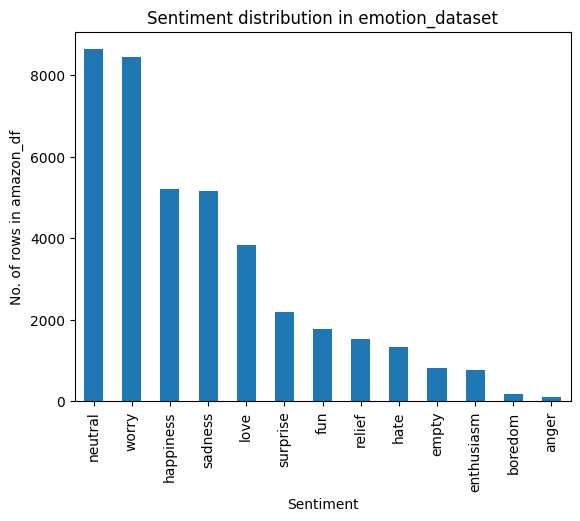

In [6]:
print("Number of rows per star rating:")
print(emotion_dataset['sentiment'].value_counts())

plt.figure()
pd.value_counts(emotion_dataset['sentiment']).plot.bar(title="Sentiment distribution in emotion_dataset")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in amazon_df")
plt.show()

In [7]:
em = emotion_dataset[emotion_dataset.sentiment != 'anger']
em = em[em.sentiment != 'empty']
em = em[em.sentiment != 'boredom']
em = em[em.sentiment != 'enthusiasm']
emotion_dataset = em

In [8]:

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].apply(lambda x:str(x).lower())
    df[column] = df[column].apply(lambda x: th.cont_exp(x))
    df[column] = df[column].apply(lambda x: th.remove_emails(x))
    df[column] = df[column].apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].apply(lambda x: th.make_base(x))
    return(df)

In [9]:
emotion_dataset = text_preprocessing(emotion_dataset, 'text')

In [10]:
emotion_dataset['sentiment'] = emotion_dataset.sentiment.replace({'fun':0,'happiness':1, 'hate':2, 'love':3, 'neutral':4, 'relief': 5, 'sadness': 6, 'surprise': 7, 'worry': 8})

In [11]:
from collections import defaultdict
import random
def train_val_test(dataframe):
    dictionary = defaultdict(list)
    for index, row in dataframe.iterrows():
        dictionary[row['sentiment']].append(row['text'])
    
    train_size = 70
    val_size = 20
    test_size = 10


    train_set, val_set, test_set = defaultdict(list), defaultdict(list), defaultdict(list)
    for k, v in dictionary.items():
        train_set[k] = v[:int((len(v)*train_size)/100)]
        val_set[k] = v[int((len(v)*train_size)/100):int((len(v)*train_size)/100) + int((len(v)*val_size)/100)]
        test_set[k] = v[int((len(v)*train_size)/100) + int((len(v)*val_size)/100):]
    
    train_vec, val_vec, test_vec = [], [], []

    for k,v in train_set.items():
        for x in v:
            train_vec.append([k, x])
    for k,v in val_set.items():
        for x in v:
            val_vec.append([k, x])
    for k,v in test_set.items():
        for x in v:
            test_vec.append([k, x])

    train_vec = random.sample(train_vec, len(train_vec))
    val_vec = random.sample(val_vec, len(val_vec))
    test_vec = random.sample(test_vec, len(test_vec))
    
    train_df = pd.DataFrame(train_vec, columns=['sentiment', 'text'])
    val_df = pd.DataFrame(val_vec, columns=['sentiment', 'text'])
    test_df = pd.DataFrame(test_vec, columns=['sentiment', 'text'])

    return train_df, val_df, test_df


In [12]:
train_emotion_dataset, val_emotion_dataset, test_emotion_dataset = train_val_test(emotion_dataset)

Number of rows per star rating:
4    8638
8    8459
1    5209
6    5165
3    3842
7    2187
0    1776
5    1526
2    1323
Name: sentiment, dtype: int64


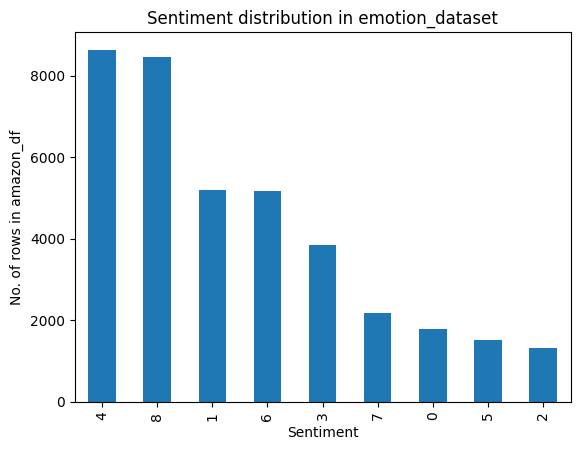

In [13]:
print("Number of rows per star rating:")
print(emotion_dataset['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(emotion_dataset['sentiment']).plot.bar(title="Sentiment distribution in emotion_dataset")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in amazon_df")
plt.show()

In [14]:
train_emotion_dataset = text_preprocessing(train_emotion_dataset, 'text')
test_emotion_dataset = text_preprocessing(test_emotion_dataset, 'text')
val_emotion_dataset = text_preprocessing(val_emotion_dataset, 'text')

In [15]:
train_emotion_dataset['sentiment'] = train_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
test_emotion_dataset['sentiment'] = test_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
val_emotion_dataset['sentiment'] = val_emotion_dataset.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [16]:
with open('datasets/processed/train_val_test/train_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(train_emotion_dataset, w)
with open('datasets/processed/train_val_test/val_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(val_emotion_dataset, w)
with open('datasets/processed/train_val_test/test_emotion_dataset.pickle', 'wb') as w:
    pickle.dump(test_emotion_dataset, w)

In [17]:
from keras.utils import to_categorical
y_train = to_categorical(train_emotion_dataset.sentiment.values)
y_test = to_categorical(test_emotion_dataset.sentiment.values)
y_val = to_categorical(val_emotion_dataset.sentiment.values)

In [33]:
from keras.preprocessing.text import Tokenizer 
num_words = 15000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([train_emotion_dataset['text'], test_emotion_dataset.text], axis = 0)
tokenizer.fit_on_texts(df_total)

In [34]:
with open('models/tokenizer', 'wb') as w:
    pickle.dump(tokenizer, w)

In [35]:
from keras.utils.data_utils import pad_sequences

In [36]:

X_train=tokenizer.texts_to_sequences(train_emotion_dataset['text'])
X_train_pad=pad_sequences(X_train,maxlen= 300,padding='post') 
X_test = tokenizer.texts_to_sequences(test_emotion_dataset.text)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(val_emotion_dataset.text)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [37]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [38]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

(15000, 100)

In [39]:
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(vector_size)

In [40]:
import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

In [41]:

EMBEDDING_DIM = vector_size
class_num = 9
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [43]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_val_pad, y_val),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25


2022-12-01 17:47:02.561685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:03.070180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:03.091832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:03.982153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:04.002734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:04.922506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:47:04.957333: I tensorflow/core/grappler/optimizers/cust

223/223 [==============================] - ETA: 0s - loss: 1.8947 - accuracy: 0.3017

2022-12-01 17:50:43.843937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:44.057265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:44.075630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:45.026687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:45.046794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:46.025648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:50:46.048278: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_accuracy improved from -inf to 0.30573, saving model to ./model.h5
223/223 [==============================] - 249s 1s/step - loss: 1.8947 - accuracy: 0.3017 - val_loss: 1.9126 - val_accuracy: 0.3057
Epoch 2/25
223/223 [==============================] - ETA: 0s - loss: 1.7878 - accuracy: 0.3479
Epoch 2: val_accuracy improved from 0.30573 to 0.36937, saving model to ./model.h5
223/223 [==============================] - 228s 1s/step - loss: 1.7878 - accuracy: 0.3479 - val_loss: 1.7848 - val_accuracy: 0.3694
Epoch 3/25
223/223 [==============================] - ETA: 0s - loss: 1.7513 - accuracy: 0.3640
Epoch 3: val_accuracy did not improve from 0.36937
223/223 [==============================] - 229s 1s/step - loss: 1.7513 - accuracy: 0.3640 - val_loss: 1.7546 - val_accuracy: 0.3581
Epoch 4/25
223/223 [==============================] - ETA: 0s - loss: 1.7263 - accuracy: 0.3714
Epoch 4: val_accuracy did not improve from 0.36937
223/223 [==============================] - 246s 1s

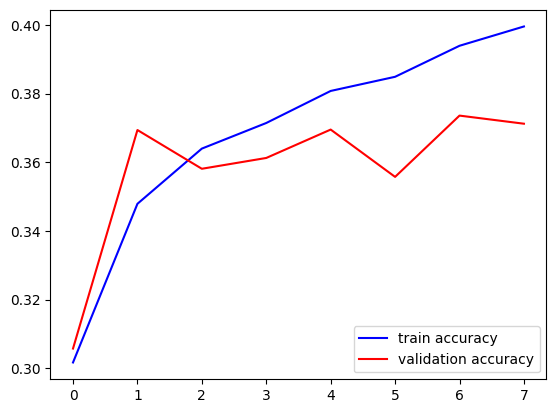

In [44]:
plt.plot(history_embedding.history['accuracy'], c='b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'], c='r', label = 'validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [45]:
y_pred = np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

2022-12-01 18:18:48.473517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:48.682953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:48.697684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:49.785134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:49.798688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:50.779851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 18:18:50.793601: I tensorflow/core/grappler/optimizers/cust

120/120 [==============================] - 38s 286ms/step
              precision    recall  f1-score   support

           0       0.01      0.08      0.01        12
           1       0.52      0.23      0.32      1158
           2       0.11      0.58      0.19        26
           3       0.50      0.36      0.42       535
           4       0.65      0.34      0.45      1649
           5       0.03      0.13      0.04        30
           6       0.09      0.40      0.15       116
           7       0.01      0.27      0.03        11
           8       0.10      0.29      0.14       283

    accuracy                           0.31      3820
   macro avg       0.22      0.30      0.19      3820
weighted avg       0.52      0.31      0.37      3820



In [46]:
model.save_weights('models/RNNLSTM_weights')

In [47]:
model.save('models/RNNLSTM')

INFO:tensorflow:Assets written to: models/RNNLSTM/assets


INFO:tensorflow:Assets written to: models/RNNLSTM/assets
